<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据源" data-toc-modified-id="数据源-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据源</a></span><ul class="toc-item"><li><span><a href="#NO2" data-toc-modified-id="NO2-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NO2</a></span></li><li><span><a href="#HCHO" data-toc-modified-id="HCHO-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>HCHO</a></span></li></ul></li><li><span><a href="#地图呈现" data-toc-modified-id="地图呈现-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>地图呈现</a></span><ul class="toc-item"><li><span><a href="#全球形势" data-toc-modified-id="全球形势-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>全球形势</a></span></li><li><span><a href="#放缩至中国并剪切" data-toc-modified-id="放缩至中国并剪切-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>放缩至中国并剪切</a></span></li></ul></li><li><span><a href="#比值操作" data-toc-modified-id="比值操作-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>比值操作</a></span></li></ul></div>

In [318]:
# library
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import cartopy
from cartopy.io.img_tiles import StamenTerrain
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import BORDERS
from cartopy.io.img_tiles import StamenTerrain
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from shapely.geometry.polygon import LinearRing
%matplotlib inline
from cartopy.io.img_tiles import GoogleTiles
class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
#         url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
#                'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
#                z=z, y=y, x=x)
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)  
#         url = ('https://tile.osm.ch/switzerland/{z}/{x}/{y}.png').format(
#                z=z, y=y, x=x)  
        return url

import matplotlib.patches as mpatches
from matplotlib import rc
rc('text', usetex=True)

# 数据源

In [46]:
from netCDF4 import Dataset

## NO2

In [442]:
NO2_file = "/Users/HYF/Documents/Satellite/Wu_SHIJIE/CH2O-NO2/OMINO2_201307.nc"
df = Dataset(NO2_file, 'r')   
no2_ = df.variables["OMNO2d_003_ColumnAmountNO2TropCloudScreened"][:]
lat = df.variables['lat'][:]
lon = df.variables['lon'][:]
no2_[no2<0]=np.nan

## HCHO

In [443]:
def read_dat(filename):
    ncols = np.array(linecache.getline(filename, 5)[31:35]).astype(float)
    nrows = np.array(linecache.getline(filename, 5)[56:59]).astype(float)
    cellsize = np.array(linecache.getline(filename, 5)[18:22]).astype(float)
    xllcorner = np.array(linecache.getline(filename, 6)[18:25]).astype(float)
    yllcorner = np.array(linecache.getline(filename, 7)[16:23]).astype(float)
    longitude = xllcorner + cellsize * np.arange(ncols)
    latitude = yllcorner + cellsize * np.arange(nrows)
    value = np.loadtxt(filename, skiprows=7)
    return longitude, latitude, value
def isNaN(num):
    return num != num

In [444]:
ch2o_file = '/Users/HYF/Documents/Satellite/Wu_SHIJIE/CH2O-NO2/OMIH2CO_Grid_720x1440_201307.dat'
lon,lat,value,= read_dat(ch2o_file)
ch2o_ = value[::-1]
ch2o_[ch2o_<0]=np.nan
print (lat.shape,lon.shape)

(720,) (1440,)


In [419]:
ch2o_[~isNaN(ch2o_)].min()

-0.0

# 地图呈现

## 全球形势

/Users/HYF/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


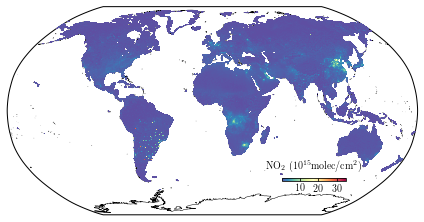

In [445]:
extent=(-180,180, -75, 75)
#extent=(75,135, 10,55)
fig   = plt.figure()
ax = plt.axes( projection=ccrs.Robinson())
xx,yy = np.meshgrid(lon,lat)
value_mask = np.ma.masked_array(no2, np.isnan(no2))
value_mask = np.ma.masked_less(value_mask, 0)
mdata = maskoceans(xx, yy, value_mask)
#mdata = value_mask
em_ = ax.pcolormesh(xx,yy,mdata/1E15, cmap = plt.cm.Spectral_r, alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4)
#ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.coastlines(linewidth = 0.5,resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
fig.canvas.draw()
ax.set_global()

cbaxes = fig.add_axes([0.66, 0.255, 0.15, 0.012]) 
cbar = plt.colorbar(em_,cax=cbaxes,orientation='horizontal')
cbar.ax.tick_params(color='k', direction='in',labelsize=10)
cbar.set_label(r'$\mathrm{NO_2\ (10^{15}molec/cm^2)}$', fontsize = 10,labelpad =-32)    
# cbar.ax.set_title(r'$\mathregular{NO_2\ (10^{15}molec/cm^2)}$', fontsize = 10)#rotation=270, 
plt.tight_layout()
#plt.savefig("%s.pdf"%(date_))
#plt.savefig("%s.png"%(date_),dpi = 400)


## 放缩至中国并剪切

In [446]:
# 矩形截切
extent=(73, 136, 17, 52)
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
nx_st = np.where(lon == (find_nearest(lon,extent[0])))[0][0]
nx_en = np.where(lon == (find_nearest(lon,extent[1] )))[0][0]
ny_st = np.where(lat == (find_nearest(lat,extent[2])))[0][0]
ny_en = np.where(lat == (find_nearest(lat,60 )))[0][0]
lon_,lat_ = lon[nx_st:nx_en+1], lat[ny_st:ny_en+1]
no2_asia= no2_[ny_st:ny_en+1, nx_st:nx_en+1]
ch2o_asia= ch2o_[ny_st:ny_en+1, nx_st:nx_en+1]

In [447]:
ch2o_[~isNaN(ch2o_)].max()

40.292

In [448]:
cn    = fiona.open("./DATA/CHN_SHP/china.shp")
pol   = cn.next()
geom  = shape(pol['geometry'])
x0,x1 = geom.bounds[0],geom.bounds[2]
y0,y1 = geom.bounds[1],geom.bounds[3]
x,y   = lon_,lat_
xx,yy = np.meshgrid(x,y)
mask_ = shapely.vectorized.contains(geom,  xx,yy)
mask_ = np.array(mask_)
mask_ = mask_.reshape(len(y),len(x))
no2_mask = np.ma.masked_array(no2_asia,~mask_)
ch2o_mask = np.ma.masked_array(ch2o_asia,~mask_)

/Users/HYF/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


In [449]:
extent=(73, 136, 17, 54)
def back_china(ax):
#    ax.add_feature(cartopy.feature.LAND,facecolor ='none',alpha=0.5)
    ax.add_feature(cartopy.feature.OCEAN,facecolor ='white')
    ax.add_feature(cartopy.feature.LAKES, facecolor ='white') 
    fname = r'/Users/HYF/Dropbox/data/geo/shp/china_basic_map/country1.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                    ccrs.PlateCarree(), facecolor='None',edgecolor ='grey',linewidth = 0.3)
    ax.add_feature(shape_feature,zorder = 1)        
    fname =r'/Users/HYF/Dropbox/data/geo/shp/china_basic_map/bou2_4l.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                    ccrs.PlateCarree(), facecolor='None',edgecolor ='w',linewidth = 0.3)
    ax.add_feature(shape_feature, zorder =4)

    sea_name = r'/Users/HYF/Dropbox/赤峰项目/TRACE/IPYNB/data/INPUT/GIS/nanhai/nanhai.shp'
    shape_feature = ShapelyFeature(Reader(sea_name).geometries(),
                                    ccrs.PlateCarree(), facecolor='k',edgecolor ='k',linewidth=0.5)
    ax.add_feature(shape_feature, zorder =5)
    
    fname =r'/Users/HYF/Dropbox/data/geo/shp/china_basic_map/bou1_4l.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                    ccrs.PlateCarree(), facecolor='None',edgecolor ='k',linewidth = 0.4)
    ax.add_feature(shape_feature, zorder =4)   
    

    ax.set_xticks(np.arange(extent[0]+2, extent[1]+2, 15), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(extent[2]+3, extent[3], 15), crs=ccrs.PlateCarree())
    ax.set_xticklabels([r'$\mathrm{75^o E}$',r'$\mathrm{90^o E}$',r'$\mathrm{105^o E}$',\
                       r'$\mathrm{120^o E}$',r'$\mathrm{135^o E}$',])
    ax.set_yticklabels([r'$\mathrm{20^o N}$',r'$\mathrm{35^o N}$',r'$\mathrm{50^o N}$'])
    ax.set_extent(extents=extent, crs=ccrs.PlateCarree())
    from mpl_toolkits.axes_grid.inset_locator import inset_axes
#     ax1= fig.add_axes([.35, .14, 0.695, .2275],projection=ccrs.PlateCarree())
#     ax1.set_extent(extents=[106,123,2,25], crs=ccrs.Geodetic())
#     ax1.add_feature(cartopy.feature.LAND,facecolor ='#E5E5E5',alpha=0.5)
#     ax1.add_feature(cartopy.feature.OCEAN,facecolor ='white')
#     ax1.add_feature(cartopy.feature.LAKES, facecolor ='white')
#     ax1.spines['bottom'].set_linewidth(0.1)
#     ax1.spines['left'].set_linewidth(0.1)
#     fname = '/Users/HYF/Dropbox/data/geo/shp/china_basic_map/bou1_4l.shp'
#     shape_feature = ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(),facecolor='#E5E5E5', edgecolor ='k', linewidth = 0.5, alpha =0.75)
#     ax1.add_feature(shape_feature, zorder =5)    
    return ax

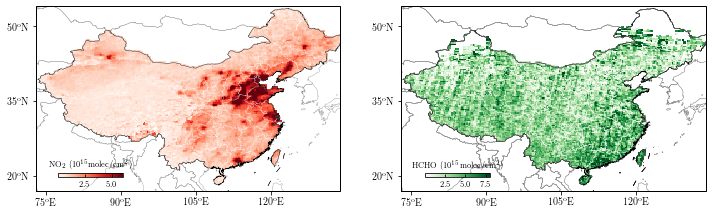

In [472]:
extent=(73, 134, 17, 54)
fig   = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_extent(extents=extent, crs=ccrs.PlateCarree())
t = ax.pcolormesh(xx,yy,no2_mask/1E15, cmap = plt.cm.Reds, alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4, vmin=1E-4, vmax=6)
cbaxes = fig.add_axes([0.15, 0.32, 0.075, 0.01]) 
cbar = plt.colorbar(t,cax=cbaxes,orientation='horizontal')
cbar.ax.tick_params(color='k', direction='in',labelsize=8)
cbar.set_label(r'$\mathrm{NO_2\ (10^{15}molec/cm^2)}$', fontsize = 8,labelpad =-28)    
back_china(ax)

ax = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent(extents=extent, crs=ccrs.PlateCarree())
t = ax.pcolormesh(xx,yy,ch2o_mask, cmap = plt.cm.Greens, alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4,vmin=1E-4, vmax=8)
back_china(ax)
cbaxes = fig.add_axes([0.575, 0.32, 0.075, 0.01]) 
cbar = plt.colorbar(t,cax=cbaxes,orientation='horizontal')
cbar.ax.tick_params(color='k', direction='in',labelsize=8)
cbar.set_label(r'$\mathrm{HCHO\ (10^{15}molec/cm^2)}$', fontsize = 8,labelpad =-28)    
back_china(ax)


# # back_china(ax)
# # plt.pcolormesh(xx,yy,zz_mask/1E15, cmap = plt.cm.RdYlGn_r, alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4)

# 比值操作

In [473]:
#ch2o_s = np.ma.masked_array(ch2o_mask, np.isnan(ch2o_mask))
#no2_s = np.ma.masked_array(no2_mask, np.isnan(no2_mask))
ratio      = ch2o_asia/no2_asia*1e15
binlabel = np.zeros_like(ratio)
binlabel[ratio<1] = 1
binlabel[(ratio>1)&(ratio<2)] = 2
binlabel[ratio<0] = 3
binlabel_mask = np.ma.masked_less_equal(binlabel, 0)
ratio_mask = np.ma.masked_array(binlabel_mask,~mask_)

In [521]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['#FE7702', 'gold','#1C72AA','b'])
bounds=[0,1,2,5]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [522]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

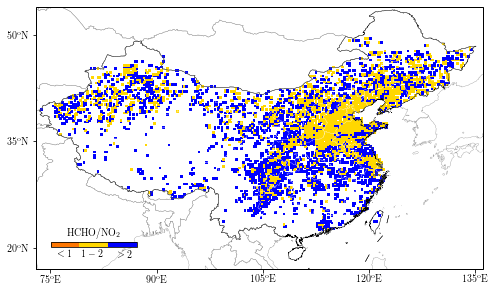

In [540]:
extent=(73, 136, 17, 54)
fig   = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extents=extent, crs=ccrs.PlateCarree())
rat_ = ax.pcolormesh(xx,yy,ratio_mask, cmap =cmap, norm = norm,\
           alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4)

cbaxes = fig.add_axes([0.15, 0.2, 0.15, 0.012]) 
cbar = plt.colorbar(rat_,cax=cbaxes,orientation='horizontal')
cbar.ax.tick_params(color='k', labelsize=10)
cbar.set_label(r'$\mathrm{HCHO/NO_2}$', fontsize = 10,labelpad =-30)    

labels = [0.5,1.45,3.75]
loc    = labels
cbar.set_ticks(loc)
cbar.ax.set_xticklabels([r'$\mathrm{<1}$',
                         r'$\mathrm{1-2}$',
                         r'$\mathrm{>2}$']) 
cbar.ax.tick_params(size=0)
back_china(ax)
# plt.pcolormesh(xx,yy,ch2o_mask/1E15, cmap = plt.cm.RdYlGn_r, alpha = 1.0, transform=ccrs.PlateCarree(),zorder =4)